# NEU-Regression: Simulation Experiments
---

### Functions from the paper:
 - 1) $\min\{\exp(\frac{-1}{(1+x)^2}),x+\cos(x)\}$. Reason: Evaluate performance for pasted functions and general badness.
 - 2) $\cos(\exp(-x))$.  Reason: Evaluate performance for non-periodic osculations.
 - 3) $I_{(-\infty,\frac1{2})}$.  Reason: Evaluation performance on a single jump.  
 
 ---

# Generate Training Data

In [1]:
# First Round Initializations (Global Level) #
#============================================#
# Load Dependances and makes path(s)
exec(open('Initializations_Dump.py').read())
# Load Hyper( and meta) parameter(s)
exec(open('HyperParameter_Grid.py').read())
# %run Helper_Functions.ipynb
exec(open('Helper_Functions.py').read())
# Load Models
# %run Architecture_Builder.ipynb
exec(open('Architecture_Builder.py').read())

Using TensorFlow backend.


Parameter Grids Build and Loaded!
Complete NEU-Structure Building Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Deep Feature Builder - Ready
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!


When generating data...you may use one of the following options:
- For evaluating non-localy patterns: "nonlocality"
- For evaluating model performance when faced with non-stationary osculatory behaviour: "oscilatory"
- For evaluating jump-type performance when faced with a discontinuity: "jumpdiscontinuity"
- For fun: "the_nightmare"

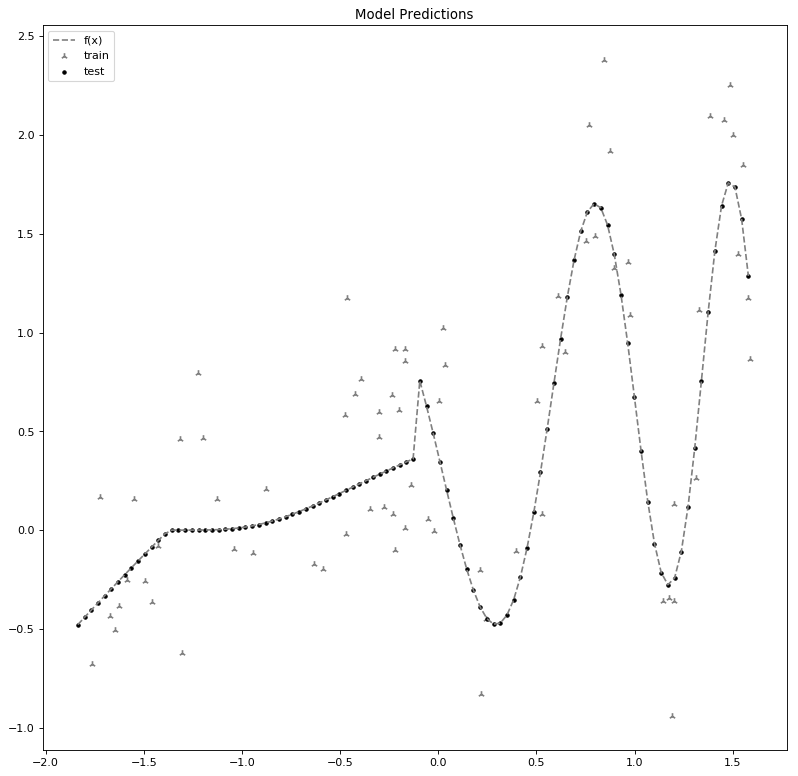

Simulation Confiugration Information:
 
We're plotting the function: the_nightmare with 0.5 additive noise, a distortion/model uncertainty level of0, and an out-of sample window on either side of the input space of:0.01.  We train using 100 datapoints and have a test set conisting of 0.75% percent of the total generated data.
 


In [2]:
#------------------------#
# Run External Notebooks #
#------------------------#
# Generate Data
Option_Function = "the_nightmare"
# %run Data_Generator.ipynb
exec(open('Data_Generator.py').read())

**TEMP:**

Data Driven Robustness Rule:
Using [this article](https://www.sciencedirect.com/science/article/pii/S0378375815000403) for the variance estimate.  
$$
\hat{\sigma}^2 \triangleq
\frac1{(n-1)}\sum_{1<n\leq N} (y_n - y_{n-1})^2
.
$$

We couple it to the problem via the following
$$
\underset{\underset{0\leq w_n\leq 1}{\sum_{n\leq N} w_n=1}}{\operatorname{argmax}} \sum_{n\leq N} w_n L(f(x_n),\hat{f}(x_n),x_n) - \sigma^2 \sum_{n\leq N} w_n \ln\left(\frac{w_n}{N}\right)
.
$$

In [3]:
# GET STATISTICAL VARIANCE ESTIMATE
var_estimate = np.sum(np.diff(data_y)**2)/(((data_y.shape[0])-1))
var_estimate = np.float(round(var_estimate,3))

robustness_dictionary = {'robustness_parameter': [var_estimate,var_estimate*2,var_estimate*3]}
#==================================================================================#        
### Create NEU parameter disctionary by parameters joining model it is upgrading ###
#==================================================================================#
param_grid_Vanilla_Nets = {**Training_dictionary,
                       **Vanilla_ffNN_dictionary,
                       **Epochs_dictionary}

param_grid_NEU_Nets = {**Training_dictionary,
                       **robustness_dictionary,
                       **Vanilla_ffNN_dictionary,
                       **param_grid_NEU_readout_extra_parameters,
                       **param_grid_NEU_feature_extra_parameters,
                       **NEU_Epochs_Feature_dictionary_coupled}

param_grid_NEU_Feature_Only_Nets = {**Training_dictionary,
                                    **robustness_dictionary,
                                    **param_grid_NEU_feature_extra_parameters,
                                    **NEU_Epochs_Feature_dictionary}

NEU_Structure_Dictionary = {**Training_dictionary,
                            **robustness_dictionary,
                            **param_grid_NEU_readout_extra_parameters,
                            **NEU_Epochs_dictionary}

# Benchmark Models

Run univariate regression benchmarks file:

In [4]:
# %run Univariate_Regression_Benchmark_Models.ipynb
exec(open('Univariate_Regression_Benchmark_Models.py').read())

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Batch computation too fast (0.0961s.) Setting batch_size=2.


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    2.8s finished


Epoch 1/100
2/2 [==============================] - 0s 1ms/step - loss: 0.7309 - mse: 0.9308 - mae: 0.7309 - mape: 122.7191
Epoch 2/100
2/2 [==============================] - 0s 1ms/step - loss: 0.7307 - mse: 0.9303 - mae: 0.7307 - mape: 122.4397
Epoch 3/100
2/2 [==============================] - 0s 1ms/step - loss: 0.7305 - mse: 0.9298 - mae: 0.7305 - mape: 122.1351
Epoch 4/100
2/2 [==============================] - 0s 1ms/step - loss: 0.7304 - mse: 0.9293 - mae: 0.7304 - mape: 121.8438
Epoch 5/100
2/2 [==============================] - 0s 1ms/step - loss: 0.7302 - mse: 0.9289 - mae: 0.7302 - mape: 121.4548
Epoch 6/100
2/2 [==============================] - 0s 1ms/step - loss: 0.7300 - mse: 0.9284 - mae: 0.7300 - mape: 121.1687
Epoch 7/100
2/2 [==============================] - 0s 1ms/step - loss: 0.7298 - mse: 0.9279 - mae: 0.7298 - mape: 120.9452
Epoch 8/100
2/2 [==============================] - 0s 1ms/step - loss: 0.7296 - mse: 0.9274 - mae: 0.7296 - mape: 120.5780
Epoch 9/100
2/2 

2/2 [==============================] - 0s 1ms/step - loss: 0.7197 - mse: 0.9010 - mae: 0.7197 - mape: 105.2624
Epoch 68/100
2/2 [==============================] - 0s 1ms/step - loss: 0.7196 - mse: 0.9005 - mae: 0.7196 - mape: 105.0383
Epoch 69/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7194 - mse: 0.9001 - mae: 0.7194 - mape: 104.7923
Epoch 70/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7192 - mse: 0.8996 - mae: 0.7192 - mape: 104.5342
Epoch 71/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7191 - mse: 0.8991 - mae: 0.7191 - mape: 104.3035
Epoch 72/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7189 - mse: 0.8987 - mae: 0.7189 - mape: 103.9617
Epoch 73/100
2/2 [==============================] - 0s 1ms/step - loss: 0.7187 - mse: 0.8983 - mae: 0.7187 - mape: 103.8132
Epoch 74/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7186 - mse: 0.8978 - mae: 0.7186 - mape: 103.5665
Epoch 75/100
2/2 [===

## Initializations:
- Load Dependancies,
- Makes Paths if missing.

In [5]:
# Second Round Re-Initializations (Global Level) #
#================================================#
# %run Helper_Functions.ipynb
exec(open('Helper_Functions.py').read())
# Load Models
# %run Architecture_Builder.ipynb
exec(open('Architecture_Builder.py').read())

Complete NEU-Structure Building Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Deep Feature Builder - Ready
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!
Complete NEU-ffNN Training Procedure!!!


#### Boost input dimension if $d=1$, so that reconfigurations can be universal.

In [6]:
if d<= 1:
    # Backup data
    data_x_raw = data_x
    data_x_test_raw = data_x_test
    # Bump Dimension so Reconfiguration network properties hold
    data_x = np.concatenate([data_x,data_x],axis=1)
    data_x_test = np.concatenate([data_x_test,data_x_test],axis=1)
    d = d+1
else:
    # Backup data
    data_x_raw = data_x
    data_x_test_raw = data_x_test
    print("Modified Input since Dimension is too low")

---
# Train Feature Map for "decoupled" NEU-*Model(s)*
---

We train NEU's universal linearizing feature map.

In [7]:
tf.random.set_seed(2020)
# 1+2) Learn Linearizing Feature Map #
#====================================#
# Obtain NEU-OLS predictions and Model
NEU_OLS_y_hat_train_pre, NEU_OLS_y_hat_test_pre, NEU_OLS = build_NEU_OLS(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = param_grid_NEU_Feature_Only_Nets, 
                                                           X_train = data_x, 
                                                           y_train = data_y,
                                                           X_test = data_x_test)
# Extract Linearizing Feature Map
Linearizing_Feature_Map = extract_trained_feature_map(NEU_OLS.model)

# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
data_x_featured_train = Linearizing_Feature_Map.predict(data_x)
data_x_featured_test = Linearizing_Feature_Map.predict(data_x_test)
# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train = np.concatenate([data_x_featured_train,NEU_OLS_y_hat_train_pre.reshape(data_x_featured_train.shape[0],D)],axis=1)
data_x_NEU_test = np.concatenate([data_x_featured_test,NEU_OLS_y_hat_test_pre.reshape(data_x_featured_test.shape[0],D)],axis=1)

# Extract Feature Data Only (for De-coupled Implementations of Step 2) #
#----------------------------------------------------------------------#
data_x_NEU_train_feature_only = data_x_NEU_train[:,:d]
data_x_NEU_test_feature_only = data_x_NEU_test[:,:d]

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   23.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   23.2s finished


Epoch 1/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0750 - mse: 0.9490 - mae: 0.7362 - mape: 108.7924
Epoch 2/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0603 - mse: 0.9481 - mae: 0.7359 - mape: 108.4506
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0719 - mse: 0.9473 - mae: 0.7356 - mape: 108.2039
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0723 - mse: 0.9465 - mae: 0.7353 - mape: 108.0501
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0702 - mse: 0.9456 - mae: 0.7350 - mape: 107.7848
Epoch 6/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0654 - mse: 0.9448 - mae: 0.7347 - mape: 107.5446
Epoch 7/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0451 - mse: 0.9439 - mae: 0.7345 - mape: 107.2261
Epoch 8/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0693 - mse: 0.9432 - mae: 0.7342 - mape: 107.0575
Epoch 9/100
2/2 

2/2 [==============================] - 0s 4ms/step - loss: 1.0381 - mse: 0.9032 - mae: 0.7202 - mape: 103.7461
Epoch 68/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0382 - mse: 0.9026 - mae: 0.7201 - mape: 103.8495
Epoch 69/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0336 - mse: 0.9020 - mae: 0.7199 - mape: 103.9624
Epoch 70/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0244 - mse: 0.9014 - mae: 0.7196 - mape: 103.9819
Epoch 71/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0368 - mse: 0.9007 - mae: 0.7194 - mape: 104.0781
Epoch 72/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0266 - mse: 0.9000 - mae: 0.7192 - mape: 104.2551
Epoch 73/100
2/2 [==============================] - 0s 5ms/step - loss: 1.0361 - mse: 0.8995 - mae: 0.7190 - mape: 104.3513
Epoch 74/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0144 - mse: 0.8989 - mae: 0.7188 - mape: 104.3067
Epoch 75/100
2/2 [===

---
# Linear Model(s)
---

### NEU-Linear *(decoupled implementation)*

In [8]:
# 2) Perform Linear Regression on Feature-Space #
#===============================================#
#====================================#
# Ordinary Linear Regression Version #
#====================================#
# NEU_lin_reg = LinearRegression()
# NEU_lin_reg.fit(data_x_featured_train,data_y)

#=====================#
# Elastic Net Version #
#=====================#
# Block warnings that spam when performing coordinate descent (by default) in 1-d.
import warnings
warnings.filterwarnings("ignore")
# Initialize Elastic Net Regularization Model
NEU_lin_reg = ElasticNetCV(cv=5, random_state=0, alphas = np.linspace(0,(10**2),(10**2)),
                           l1_ratio=np.linspace(0,1,(10**2)))
# Fit Elastic Net Model
NEU_lin_reg.fit(data_x_featured_train,data_y)

ElasticNetCV(alphas=array([  0.        ,   1.01010101,   2.02020202,   3.03030303,
         4.04040404,   5.05050505,   6.06060606,   7.07070707,
         8.08080808,   9.09090909,  10.1010101 ,  11.11111111,
        12.12121212,  13.13131313,  14.14141414,  15.15151515,
        16.16161616,  17.17171717,  18.18181818,  19.19191919,
        20.2020202 ,  21.21212121,  22.22222222,  23.23232323,
        24.24242424,  25.25252525,  26.26262626,  27.27272727,
        28.2828...
       0.80808081, 0.81818182, 0.82828283, 0.83838384, 0.84848485,
       0.85858586, 0.86868687, 0.87878788, 0.88888889, 0.8989899 ,
       0.90909091, 0.91919192, 0.92929293, 0.93939394, 0.94949495,
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ]),
             max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
             positive=False, precompute='auto', random_state=0,
             selection='cyclic', tol=0.0001, verbose=0)

In [9]:
# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
# Produce Prediction(s)
NEU_OLS_y_hat_train = NEU_lin_reg.predict(data_x_featured_train)
NEU_OLS_y_hat_test = NEU_lin_reg.predict(data_x_featured_test)
# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train = np.concatenate([data_x_featured_train,
                                   NEU_OLS_y_hat_train.reshape(data_x_featured_train.shape[0],D)],axis=1)
data_x_NEU_test = np.concatenate([data_x_featured_test,
                                  NEU_OLS_y_hat_test.reshape(data_x_featured_test.shape[0],D)],axis=1)
# 3) Learn Structure Map #
#========================#
NEU_OLS_y_hat_train, NEU_OLS_y_hat_test = build_NEU_Structure(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = NEU_Structure_Dictionary, 
                                                           X_train = data_x_NEU_train, 
                                                           y_train = data_y,
                                                           X_test = data_x_NEU_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    9.0s finished


Epoch 1/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0883 - mse: 0.9655 - mae: 0.7410 - mape: 108.6908
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0721 - mse: 0.9645 - mae: 0.7406 - mape: 109.0303
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0854 - mse: 0.9636 - mae: 0.7404 - mape: 109.2581
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 1.0856 - mse: 0.9627 - mae: 0.7401 - mape: 109.3705
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0832 - mse: 0.9618 - mae: 0.7398 - mape: 109.6007
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0781 - mse: 0.9609 - mae: 0.7395 - mape: 109.8009
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0574 - mse: 0.9599 - mae: 0.7392 - mape: 110.1514
Epoch 8/100
2/2 [==============================] - 0s 2ms/step - loss: 1.0819 - mse: 0.9591 - mae: 0.7389 - mape: 110.2697
Epoch 9/100
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 1.0392 - mse: 0.9042 - mae: 0.7208 - mape: 123.6846
Epoch 68/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0395 - mse: 0.9032 - mae: 0.7204 - mape: 123.9311
Epoch 69/100
2/2 [==============================] - 0s 4ms/step - loss: 1.0340 - mse: 0.9022 - mae: 0.7201 - mape: 124.1575
Epoch 70/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0248 - mse: 0.9012 - mae: 0.7198 - mape: 124.4261
Epoch 71/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0370 - mse: 0.9003 - mae: 0.7195 - mape: 124.6691
Epoch 72/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0259 - mse: 0.8993 - mae: 0.7191 - mape: 125.0217
Epoch 73/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0358 - mse: 0.8983 - mae: 0.7188 - mape: 125.2738
Epoch 74/100
2/2 [==============================] - 0s 3ms/step - loss: 1.0141 - mse: 0.8973 - mae: 0.7184 - mape: 125.3941
Epoch 75/100
2/2 [===

#### Visual Comaprison between the OLS and the NEU-OLS models:

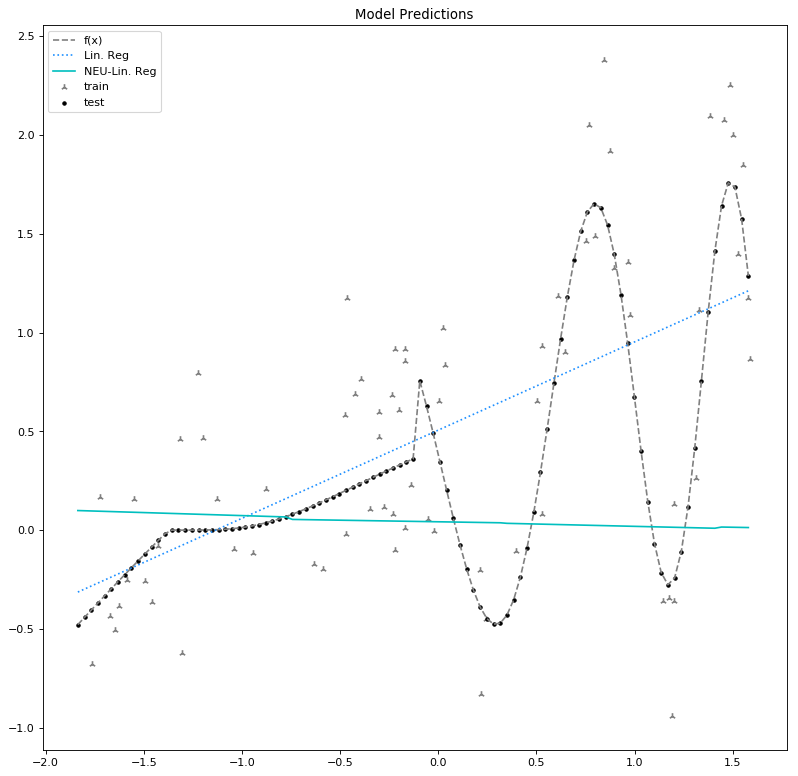

In [10]:
# Initialize Plot #
#-----------------#
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#----------#
# Model(s) #
#----------#
# Ordinary Linear Regression (OLS)
plt.plot(np.array(data_x_test_raw).reshape(-1,),ENET_OLS_y_hat_test, color = 'dodgerblue',linestyle=":", label='Lin. Reg')
#plt.plot(np.array(data_x_test_raw).reshape(-1,),OLS_y_hat_test, color = 'dodgerblue',linestyle=":", label='Lin. Reg')
# Plot NEU-OLS
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_OLS_y_hat_test, color = 'c',label='NEU-Lin. Reg')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/OLS.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

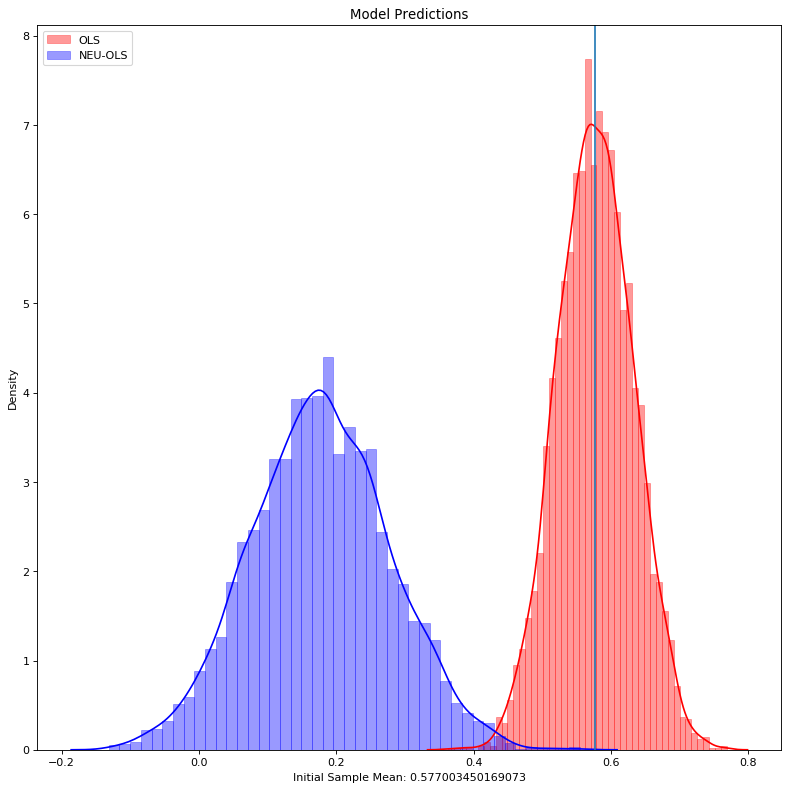

In [11]:
get_Error_distribution_plots(data_y_test,ENET_OLS_y_hat_test,NEU_OLS_y_hat_test,"OLS")

#### Comparison between Elastic-Net and NEU-ENET

In [12]:
#-----------------------#
# Kernel Ridge Model(s) #
#-----------------------#
# Kernel Ridge Performance
print("Elastic-Net Performance:")
print(reporter(ENET_OLS_y_hat_train,ENET_OLS_y_hat_test,data_y,data_y_test))

# NEU-Kernel Ridge Performance
print("NEU-ENET Performance:")
print(reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test))

Elastic-Net Performance:
                 Train       Test
Er. 95L  -1.518176e-01  -0.257825
Er. Mean  6.957398e-17  -0.163956
Er. 95U   1.479701e-01  -0.070591
MAE       5.181375e-01   0.342560
MSE       4.362162e-01   0.258838
MAPE      2.151849e+02  64.415170
NEU-ENET Performance:
                Train         Test
Er. 95L      0.280532     0.120943
Er. Mean     0.461152     0.236551
Er. 95U      0.647747     0.360349
MAE          0.709040     0.447292
MSE          0.870286     0.436004
MAPE      3614.691361  1981.756680


---
# Non-Linear Models
---

### NEU-Smoothing Splines

In [13]:
# 2) Perform Linear Regression on Feature-Space #
#===============================================#
NEU_Ssplines_y_hat_train,NEU_Ssplines_y_hat_test = get_smooting_splines(data_x = (data_x_NEU_train_feature_only.mean(axis=1)),
                                                                                       data_x_test = (data_x_NEU_test_feature_only.mean(axis=1)),
                                                                                       data_y = data_y)

# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train_Ssplines = np.concatenate([data_x_featured_train,
                                   NEU_Ssplines_y_hat_train.reshape(data_x_featured_train.shape[0],D)],axis=1)
data_x_NEU_test_Ssplines = np.concatenate([data_x_featured_test,
                                  NEU_Ssplines_y_hat_test.reshape(data_x_featured_test.shape[0],D)],axis=1)
# 3) Learn Structure Map #
#========================#
NEU_Ssplines_y_hat_train, NEU_Ssplines_y_hat_test = build_NEU_Structure(n_folds = CV_folds, 
                                                                n_jobs = n_jobs, 
                                                                n_iter = n_iter, 
                                                                param_grid_in = NEU_Structure_Dictionary, 
                                                                X_train = data_x_NEU_train_Ssplines, 
                                                                y_train = data_y,
                                                                X_test = data_x_NEU_test_Ssplines)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    9.7s finished


Epoch 1/100
2/2 [==============================] - 0s 2ms/step - loss: 0.9193 - mse: 0.7561 - mae: 0.6667 - mape: 136.8994
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 0.9114 - mse: 0.7551 - mae: 0.6663 - mape: 137.2501
Epoch 3/100
2/2 [==============================] - 0s 3ms/step - loss: 0.9161 - mse: 0.7543 - mae: 0.6660 - mape: 137.5172
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 0.9166 - mse: 0.7534 - mae: 0.6657 - mape: 137.6663
Epoch 5/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9150 - mse: 0.7525 - mae: 0.6654 - mape: 137.9450
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 0.9130 - mse: 0.7516 - mae: 0.6650 - mape: 138.1678
Epoch 7/100
2/2 [==============================] - 0s 2ms/step - loss: 0.8965 - mse: 0.7507 - mae: 0.6647 - mape: 138.5257
Epoch 8/100
2/2 [==============================] - 0s 2ms/step - loss: 0.9142 - mse: 0.7498 - mae: 0.6644 - mape: 138.6998
Epoch 9/100
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 0.8669 - mse: 0.6935 - mae: 0.6433 - mape: 154.6380
Epoch 68/100
2/2 [==============================] - 0s 2ms/step - loss: 0.8650 - mse: 0.6929 - mae: 0.6430 - mape: 154.8264
Epoch 69/100
2/2 [==============================] - 0s 3ms/step - loss: 0.8647 - mse: 0.6920 - mae: 0.6427 - mape: 155.1892
Epoch 70/100
2/2 [==============================] - 0s 3ms/step - loss: 0.8575 - mse: 0.6910 - mae: 0.6423 - mape: 155.5627
Epoch 71/100
2/2 [==============================] - 0s 2ms/step - loss: 0.8639 - mse: 0.6894 - mae: 0.6417 - mape: 155.8634
Epoch 72/100
2/2 [==============================] - 0s 2ms/step - loss: 0.8564 - mse: 0.6876 - mae: 0.6410 - mape: 155.9473
Epoch 73/100
2/2 [==============================] - 0s 3ms/step - loss: 0.8622 - mse: 0.6874 - mae: 0.6411 - mape: 156.4799
Epoch 74/100
2/2 [==============================] - 0s 2ms/step - loss: 0.8462 - mse: 0.6856 - mae: 0.6405 - mape: 156.8776
Epoch 75/100
2/2 [===

#### Visual Comaprison between the Smoothing Splines and the NEU-Smoothing Splines models:

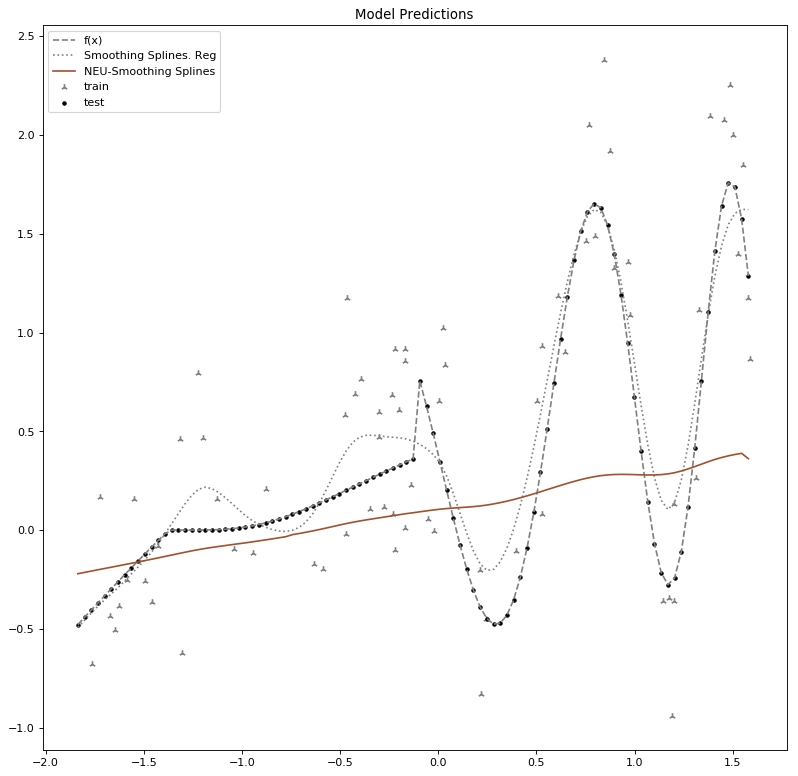

In [14]:
# Initialize Plot #
#-----------------#
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#----------#
# Model(s) #
#----------#
# Ordinary Linear Regression (OLS)
plt.plot(np.array(data_x_test_raw).reshape(-1,),f_hat_smoothing_splines_test, color = 'grey',linestyle=":", label='Smoothing Splines. Reg')
#plt.plot(np.array(data_x_test_raw).reshape(-1,),OLS_y_hat_test, color = 'dodgerblue',linestyle=":", label='Lin. Reg')
# Plot NEU-OLS
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_Ssplines_y_hat_test, color = 'sienna',label='NEU-Smoothing Splines')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/OLS.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

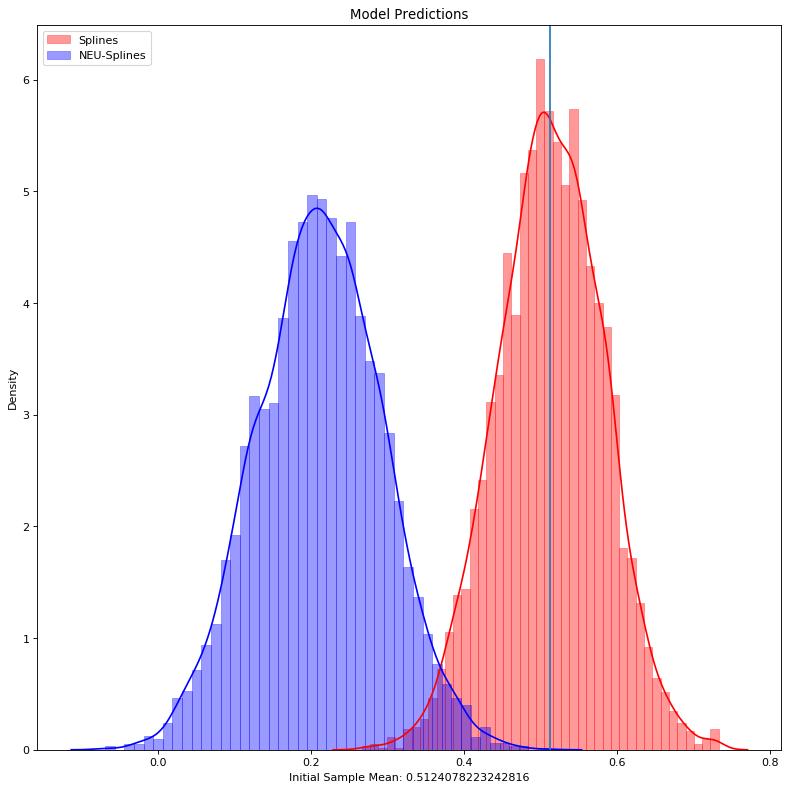

In [15]:
get_Error_distribution_plots(data_y_test,f_hat_smoothing_splines_test,NEU_Ssplines_y_hat_test,"Splines")

#### Numerical Comparison between the Smoothing Splines regressor and NEU-Smoothing Splines regressor models:

In [16]:
#-----------------------#
# Kernel Ridge Model(s) #
#-----------------------#
# Kernel Ridge Performance
print("Smoothing Splines Performance:")
print(reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test))

# NEU-Kernel Ridge Performance
print("NEU-Smoothing Splines Performance:")
print(reporter(NEU_Ssplines_y_hat_train,NEU_Ssplines_y_hat_test,data_y,data_y_test))

Smoothing Splines Performance:
                 Train        Test
Er. 95L  -9.294520e-02   -0.130106
Er. Mean -2.740030e-15   -0.099360
Er. 95U   9.198310e-02   -0.069099
MAE       3.464587e-01    0.142798
MSE       1.713013e-01    0.033205
MAPE      1.385319e+02  252.421497
NEU-Smoothing Splines Performance:
               Train        Test
Er. 95L     0.239654    0.102130
Er. Mean    0.397700    0.201225
Er. 95U     0.557506    0.302089
MAE         0.629076    0.380362
MSE         0.656472    0.293971
MAPE      564.834014  340.058844


### NEU-Kernel Ridge Regression *(decoupled implementation)*

In [17]:
# 2) Perform Linear Regression on Feature-Space #
#===============================================#
NEU_KReg_y_hat_train,NEU_KReg_y_hat_test, NEU_KReg_model = get_Kernel_Ridge_Regressor(data_x_in = data_x_featured_train,
                                                                                       data_x_test_in = data_x_featured_test,
                                                                                       data_y_in = data_y)

# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train_KReg = np.concatenate([data_x_featured_train,
                                   NEU_KReg_y_hat_train.reshape(data_x_featured_train.shape[0],D)],axis=1)
data_x_NEU_test_KReg = np.concatenate([data_x_featured_test,
                                  NEU_KReg_y_hat_test.reshape(data_x_featured_test.shape[0],D)],axis=1)
# 3) Learn Structure Map #
#========================#
NEU_KReg_y_hat_train, NEU_KReg_y_hat_test = build_NEU_Structure(n_folds = CV_folds, 
                                                                n_jobs = n_jobs, 
                                                                n_iter = n_iter, 
                                                                param_grid_in = NEU_Structure_Dictionary, 
                                                                X_train = data_x_NEU_train_KReg, 
                                                                y_train = data_y,
                                                                X_test = data_x_NEU_test_KReg)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Batch computation too fast (0.0287s.) Setting batch_size=2.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    7.4s finished


Epoch 1/100
2/2 [==============================] - 0s 3ms/step - loss: 0.9949 - mse: 0.8466 - mae: 0.6999 - mape: 122.5570
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 0.9822 - mse: 0.8448 - mae: 0.6993 - mape: 122.8120
Epoch 3/100
2/2 [==============================] - 0s 2ms/step - loss: 0.9906 - mse: 0.8432 - mae: 0.6986 - mape: 122.9820
Epoch 4/100
2/2 [==============================] - 0s 3ms/step - loss: 0.9903 - mse: 0.8415 - mae: 0.6980 - mape: 123.0971
Epoch 5/100
2/2 [==============================] - 0s 2ms/step - loss: 0.9877 - mse: 0.8398 - mae: 0.6973 - mape: 123.2680
Epoch 6/100
2/2 [==============================] - 0s 3ms/step - loss: 0.9834 - mse: 0.8381 - mae: 0.6966 - mape: 123.4415
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 0.9645 - mse: 0.8364 - mae: 0.6960 - mape: 123.6991
Epoch 8/100
2/2 [==============================] - 0s 2ms/step - loss: 0.9848 - mse: 0.8347 - mae: 0.6953 - mape: 123.8180
Epoch 9/100
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 0.8979 - mse: 0.7275 - mae: 0.6522 - mape: 138.3767
Epoch 68/100
2/2 [==============================] - 0s 3ms/step - loss: 0.8964 - mse: 0.7251 - mae: 0.6503 - mape: 136.6678
Epoch 69/100
2/2 [==============================] - 0s 3ms/step - loss: 0.8929 - mse: 0.7243 - mae: 0.6499 - mape: 137.0335
Epoch 70/100
2/2 [==============================] - 0s 3ms/step - loss: 0.8851 - mse: 0.7230 - mae: 0.6497 - mape: 137.5602
Epoch 71/100
2/2 [==============================] - 0s 4ms/step - loss: 0.8919 - mse: 0.7195 - mae: 0.6484 - mape: 137.2184
Epoch 72/100
2/2 [==============================] - 0s 2ms/step - loss: 0.8830 - mse: 0.7173 - mae: 0.6481 - mape: 137.9135
Epoch 73/100
2/2 [==============================] - 0s 3ms/step - loss: 0.8892 - mse: 0.7158 - mae: 0.6466 - mape: 137.4549
Epoch 74/100
2/2 [==============================] - 0s 3ms/step - loss: 0.8716 - mse: 0.7123 - mae: 0.6453 - mape: 138.8250
Epoch 75/100
2/2 [===

#### Visual Comaprison between the Kernel Ridge Regression and the NEU-Kernel Ridge Regression models:

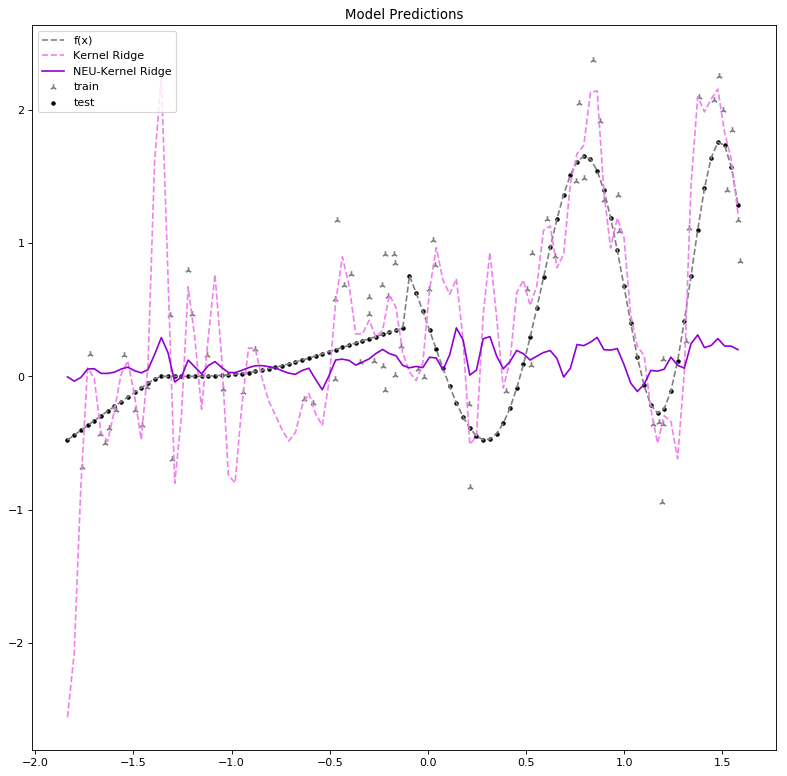

In [18]:
# Initialize Plot #
#-----------------#
fig = plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#----------#
# Model(s) #
#----------#
# Kernel Ridge Regressor
plt.plot(np.array(data_x_test_raw).reshape(-1,),f_hat_kernel_ridge_test,color='violet',linestyle="--",label='Kernel Ridge')
# NEU-Kernel Ridge Regressor
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_KReg_y_hat_test,color='darkviolet',label='NEU-Kernel Ridge')

# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Kernel_Ridge.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

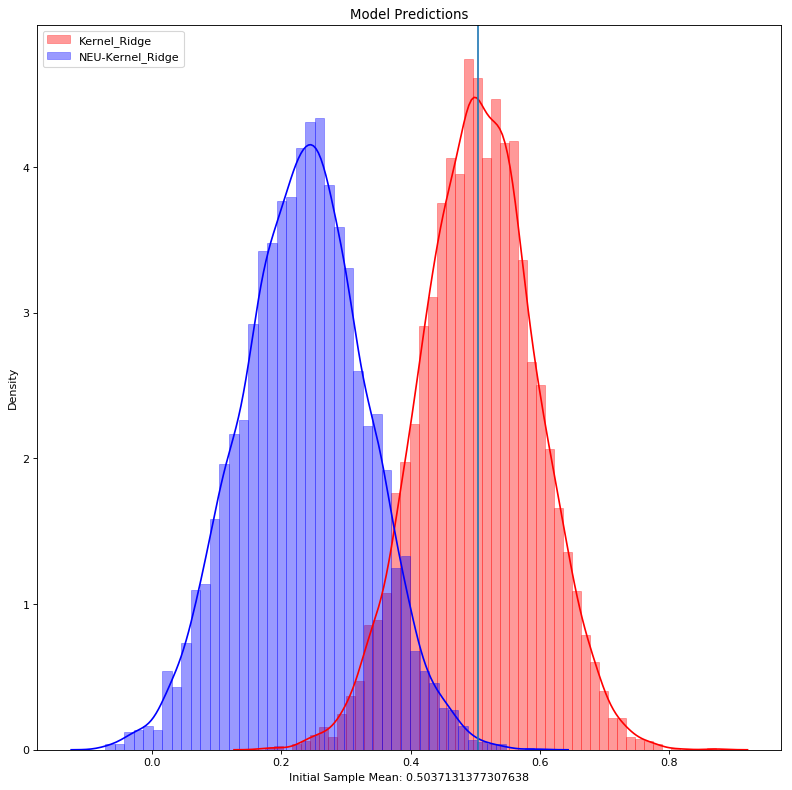

In [19]:
get_Error_distribution_plots(data_y_test,f_hat_kernel_ridge_test,NEU_KReg_y_hat_test,"Kernel_Ridge")

#### Numerical Comparison between the Kernel Ridge regressor and NEU-Kernel Ridge regressor models:

In [20]:
#-----------------------#
# Kernel Ridge Model(s) #
#-----------------------#
# Kernel Ridge Performance
print("Kernel Ridge-Performance:")
print(reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test))

# NEU-Kernel Ridge Performance
print("NEU-Kernel Ridge-Performance:")
print(reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test))

Kernel Ridge-Performance:
              Train        Test
Er. 95L   -0.051552   -0.202134
Er. Mean   0.000062   -0.090666
Er. 95U    0.052408    0.022727
MAE        0.162635    0.428352
MSE        0.052051    0.349560
MAPE      57.592129  178.340369
NEU-Kernel Ridge-Performance:
                Train        Test
Er. 95L      0.235073    0.070935
Er. Mean     0.392945    0.177866
Er. 95U      0.559835    0.291941
MAE          0.626142    0.410030
MSE          0.666075    0.348442
MAPE      2216.392570  903.501597


## Tree Model(s):
*Naturally, all of these have a decoupled implementation*.

In [21]:
# TEMP
exec(open('HyperParameter_Grid.py').read())

Parameter Grids Build and Loaded!


In [22]:
# 2) Perform Linear Regression on Feature-Space #
#===============================================#
NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test, GBRF_w_NEU_features = get_GBRF(X_train = data_x_featured_train,
                                                                         X_test = data_x_featured_test,
                                                                         y_train = data_y)

# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train_GBRF = np.concatenate([data_x_featured_train,
                                   NEU_GBRF_y_hat_train.reshape(data_x_featured_train.shape[0],D)],axis=1)
data_x_NEU_test_GBRF = np.concatenate([data_x_featured_test,
                                  NEU_GBRF_y_hat_test.reshape(data_x_featured_test.shape[0],D)],axis=1)
# 3) Learn Structure Map #
# ========================#
NEU_GBRF_y_hat_train, NEU_GBRF_y_hat_test = build_NEU_Structure(n_folds = CV_folds, 
                                                                n_jobs = n_jobs, 
                                                                n_iter = n_iter, 
                                                                param_grid_in = NEU_Structure_Dictionary, 
                                                                X_train = data_x_NEU_train_GBRF, 
                                                                y_train = data_y,
                                                                X_test = data_x_NEU_test_GBRF)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Batch computation too fast (0.0716s.) Setting batch_size=2.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    8.0s finished


Epoch 1/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7408 - mse: 0.9536 - mae: 0.7408 - mape: 161.5559
Epoch 2/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7404 - mse: 0.9526 - mae: 0.7404 - mape: 161.7964
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 0.7401 - mse: 0.9517 - mae: 0.7401 - mape: 161.9432
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7398 - mse: 0.9508 - mae: 0.7398 - mape: 162.0011
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7395 - mse: 0.9499 - mae: 0.7395 - mape: 162.1472
Epoch 6/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7391 - mse: 0.9490 - mae: 0.7391 - mape: 162.2601
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7388 - mse: 0.9481 - mae: 0.7388 - mape: 162.4588
Epoch 8/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7385 - mse: 0.9473 - mae: 0.7385 - mape: 162.5134
Epoch 9/100
2/2 

2/2 [==============================] - 0s 5ms/step - loss: 0.7204 - mse: 0.8967 - mae: 0.7204 - mape: 169.7829
Epoch 68/100
2/2 [==============================] - 0s 6ms/step - loss: 0.7203 - mse: 0.8960 - mae: 0.7203 - mape: 170.0619
Epoch 69/100
2/2 [==============================] - 0s 5ms/step - loss: 0.7200 - mse: 0.8951 - mae: 0.7200 - mape: 170.2105
Epoch 70/100
2/2 [==============================] - 0s 4ms/step - loss: 0.7196 - mse: 0.8943 - mae: 0.7196 - mape: 170.3078
Epoch 71/100
2/2 [==============================] - 0s 6ms/step - loss: 0.7193 - mse: 0.8934 - mae: 0.7193 - mape: 170.4818
Epoch 72/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7189 - mse: 0.8924 - mae: 0.7189 - mape: 170.7018
Epoch 73/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7187 - mse: 0.8917 - mae: 0.7187 - mape: 170.8783
Epoch 74/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7184 - mse: 0.8908 - mae: 0.7184 - mape: 170.8937
Epoch 75/100
2/2 [===

#### Visual Comaprison between the GBRF and the NEU-GBRF models:

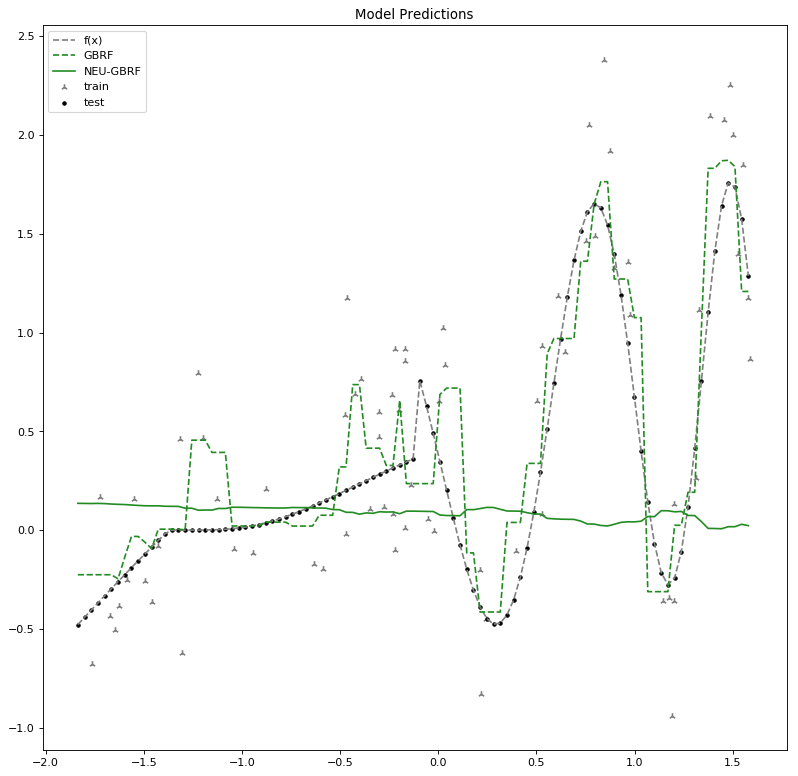

In [23]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#----------#
# Model(s) #
#----------#
# Plot Gradient-Boosted Random Forest Regressor (GBRF):
plt.plot(np.array(data_x_test_raw).reshape(-1,),GBRF_y_hat_test, linestyle="--", color = 'forestgreen', label='GBRF')
# Plot NEU-GBRF:
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_GBRF_y_hat_test, color = 'forestgreen',label='NEU-GBRF')


# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/GBRF.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

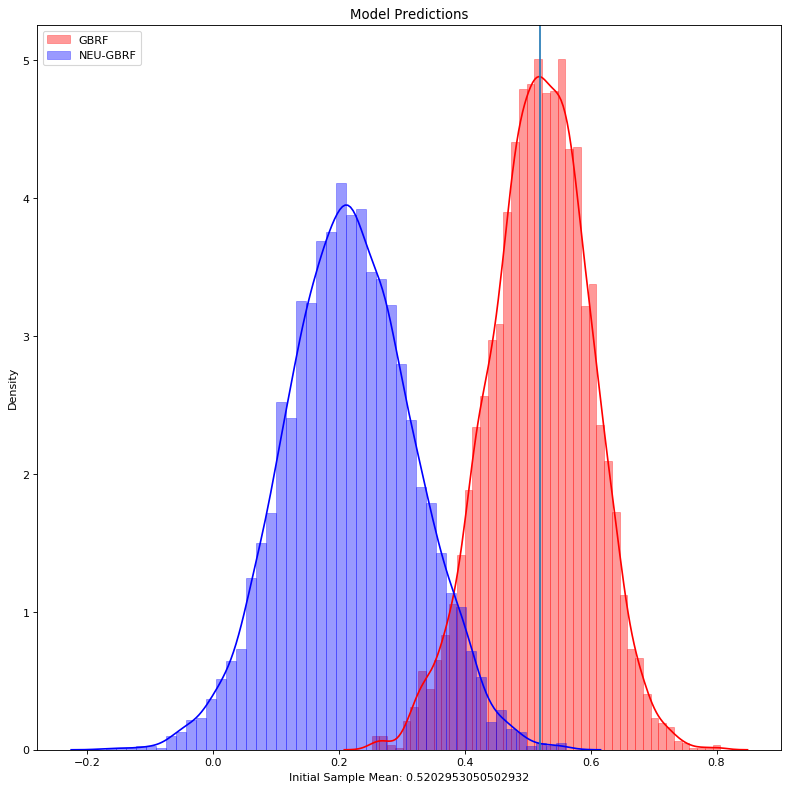

In [24]:
get_Error_distribution_plots(data_y_test,GBRF_y_hat_test,NEU_GBRF_y_hat_test,"GBRF")

#### Numerical Comparison between the GBRF and NEU-GBRF models:

In [25]:
#---------------#
# Tree Model(s) #
#---------------#
# GBRF Performance
print("GBRF-Performance:")
print(reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test))

# NEU-GBRF Performance
print("NEU-GBRF-Performance:")
print(reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test))

GBRF-Performance:
                 Train        Test
Er. 95L  -6.028686e-02   -0.156291
Er. Mean -4.218847e-17   -0.107248
Er. 95U   5.951699e-02   -0.057804
MAE       2.156814e-01    0.199944
MSE       6.948222e-02    0.074269
MAPE      1.055031e+03  133.209419
NEU-GBRF-Performance:
                Train         Test
Er. 95L      0.234982     0.075052
Er. Mean     0.423367     0.196695
Er. 95U      0.615364     0.326708
MAE          0.710289     0.453193
MSE          0.867916     0.436599
MAPE      2873.340017  1484.753436


---
## Neural Networks: 
---
### NEU-ffNN

#### Fully-Coupled Implementation

#### A) $\rho\circ\hat{f}\circ \phi$

Here we only use reconfiguration networks to learn an appropriate readout map.

In [26]:
tf.random.set_seed(2020)
NEU_ffNN_y_hat_train, NEU_ffNN_y_hat_test = build_NEU_ffNN(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = param_grid_NEU_Nets, 
                                                           X_train = data_x, 
                                                           y_train = data_y,
                                                           X_test = data_x_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   21.4s remaining:    0.0s


Epoch 1/100
2/2 [==============================] - 0s 10ms/step - loss: 0.6983 - mse: 0.8399 - mae: 0.6983 - mape: 147.7658
Epoch 2/100
2/2 [==============================] - 0s 10ms/step - loss: 0.6979 - mse: 0.8388 - mae: 0.6979 - mape: 148.7742
Epoch 3/100
2/2 [==============================] - 0s 10ms/step - loss: 0.6974 - mse: 0.8377 - mae: 0.6974 - mape: 149.5166
Epoch 4/100
2/2 [==============================] - 0s 8ms/step - loss: 0.6971 - mse: 0.8366 - mae: 0.6971 - mape: 149.9392
Epoch 5/100
2/2 [==============================] - 0s 8ms/step - loss: 0.6968 - mse: 0.8356 - mae: 0.6968 - mape: 150.6859
Epoch 6/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6963 - mse: 0.8345 - mae: 0.6963 - mape: 151.2977
Epoch 7/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6960 - mse: 0.8335 - mae: 0.6960 - mape: 152.2330
Epoch 8/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6957 - mse: 0.8326 - mae: 0.6957 - mape: 152.6879
Epoch 9/100
2

2/2 [==============================] - 0s 5ms/step - loss: 0.6769 - mse: 0.7760 - mae: 0.6769 - mape: 191.6925
Epoch 68/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6766 - mse: 0.7751 - mae: 0.6766 - mape: 192.3768
Epoch 69/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6764 - mse: 0.7741 - mae: 0.6764 - mape: 193.0316
Epoch 70/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6761 - mse: 0.7732 - mae: 0.6761 - mape: 193.6855
Epoch 71/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6759 - mse: 0.7723 - mae: 0.6759 - mape: 194.3719
Epoch 72/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6756 - mse: 0.7713 - mae: 0.6756 - mape: 195.2455
Epoch 73/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6754 - mse: 0.7704 - mae: 0.6754 - mape: 195.9311
Epoch 74/100
2/2 [==============================] - 0s 4ms/step - loss: 0.6751 - mse: 0.7695 - mae: 0.6751 - mape: 196.3559
Epoch 75/100
2/2 [===

---

**Note:** The following two models are purely out of personal curiosity and are not included in the paper.  Feel free to use them, they perform well. 

---

#### B) $\pi\circ \rho(\hat{f}\circ \phi(\cdot),\cdot)$
Here we use reconfigurations to learn an appropriate structure map. 

In [27]:
tf.random.set_seed(2020)
NEU_ffNN_y_hat_train_w_proj, NEU_ffNN_y_hat_test_w_proj = build_NEU_ffNN_w_proj(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = param_grid_NEU_Nets, 
                                                           X_train = data_x, 
                                                           y_train = data_y,
                                                           X_test = data_x_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   26.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   26.8s finished


Epoch 1/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6982 - mse: 0.8398 - mae: 0.6982 - mape: 147.7403
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6975 - mse: 0.8378 - mae: 0.6975 - mape: 148.6370
Epoch 3/100
2/2 [==============================] - 0s 7ms/step - loss: 0.6968 - mse: 0.8360 - mae: 0.6968 - mape: 149.2662
Epoch 4/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6962 - mse: 0.8341 - mae: 0.6962 - mape: 149.5826
Epoch 5/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6956 - mse: 0.8323 - mae: 0.6956 - mape: 150.2212
Epoch 6/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6948 - mse: 0.8304 - mae: 0.6948 - mape: 150.7235
Epoch 7/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6942 - mse: 0.8286 - mae: 0.6942 - mape: 151.5545
Epoch 8/100
2/2 [==============================] - 0s 7ms/step - loss: 0.6936 - mse: 0.8268 - mae: 0.6936 - mape: 151.8830
Epoch 9/100
2/2 

2/2 [==============================] - 0s 8ms/step - loss: 0.6503 - mse: 0.7050 - mae: 0.6503 - mape: 182.7907
Epoch 68/100
2/2 [==============================] - 0s 5ms/step - loss: 0.6507 - mse: 0.7042 - mae: 0.6507 - mape: 184.1778
Epoch 69/100
2/2 [==============================] - 0s 7ms/step - loss: 0.6499 - mse: 0.7021 - mae: 0.6499 - mape: 184.9011
Epoch 70/100
2/2 [==============================] - 0s 7ms/step - loss: 0.6485 - mse: 0.6998 - mae: 0.6485 - mape: 185.1331
Epoch 71/100
2/2 [==============================] - 0s 8ms/step - loss: 0.6473 - mse: 0.6961 - mae: 0.6473 - mape: 185.8731
Epoch 72/100
2/2 [==============================] - 0s 8ms/step - loss: 0.6460 - mse: 0.6919 - mae: 0.6460 - mape: 186.6343
Epoch 73/100
2/2 [==============================] - 0s 9ms/step - loss: 0.6461 - mse: 0.6915 - mae: 0.6461 - mape: 187.4959
Epoch 74/100
2/2 [==============================] - 0s 6ms/step - loss: 0.6450 - mse: 0.6881 - mae: 0.6450 - mape: 187.6406
Epoch 75/100
2/2 [===

#### Decoupled Implementation

In [28]:
tf.random.set_seed(2020)
# 1+2) Learn Linearizing Feature Map #
#====================================#
# Completed Above
print("Phase 1 Complete: Feature Map Trained/Loaded")

# 2) Train ffNN #
#===============#
NEU_ffNN_y_hat_train_dcpld, NEU_ffNN_y_hat_test_dcpld = build_ffNN(n_folds = CV_folds, 
                                                                   n_jobs = n_jobs, 
                                                                   n_iter = n_iter, 
                                                                   param_grid_in = param_grid_Vanilla_Nets,  
                                                                   X_train = data_x_NEU_train_feature_only, 
                                                                   y_train = data_y,
                                                                   X_test = data_x_NEU_test_feature_only)
# Pre-process Linearized Data #
#=============================#
# Get Linearized Predictions #
#----------------------------#
# Coerce data into form ready for NEU-Structure Map
data_x_NEU_train = np.concatenate([data_x_featured_train,
                                   NEU_ffNN_y_hat_train_dcpld.reshape(data_x_featured_train.shape[0],D)],axis=1)
data_x_NEU_test = np.concatenate([data_x_featured_test,
                                  NEU_ffNN_y_hat_test_dcpld.reshape(data_x_featured_test.shape[0],D)],axis=1)

# Update User #
#-------------#
print("Phase 2 Complete: Trained Vanilla Model")

# 3) Learn Structure Map #
#========================#
NEU_ffNN_y_hat_train_Dcpld, NEU_ffNN_y_hat_test_Dcpld = build_NEU_Structure(n_folds = CV_folds, 
                                                           n_jobs = n_jobs, 
                                                           n_iter = n_iter, 
                                                           param_grid_in = NEU_Structure_Dictionary, 
                                                           X_train = data_x_NEU_train, 
                                                           y_train = data_y,
                                                           X_test = data_x_NEU_test)

# Update User #
#-------------#
print("Phase 3 Complete: Trained NEU-Structure Map")
print("NEU Statue: Trained")

Phase 1 Complete: Feature Map Trained/Loaded
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:    4.2s finished


Epoch 1/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7296 - mse: 0.9270 - mae: 0.7296 - mape: 121.7746
Epoch 2/100
2/2 [==============================] - 0s 1ms/step - loss: 0.7293 - mse: 0.9264 - mae: 0.7293 - mape: 121.3989
Epoch 3/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7291 - mse: 0.9259 - mae: 0.7291 - mape: 121.1189
Epoch 4/100
2/2 [==============================] - 0s 1ms/step - loss: 0.7289 - mse: 0.9253 - mae: 0.7289 - mape: 120.9489
Epoch 5/100
2/2 [==============================] - 0s 1ms/step - loss: 0.7287 - mse: 0.9248 - mae: 0.7287 - mape: 120.6684
Epoch 6/100
2/2 [==============================] - 0s 1ms/step - loss: 0.7285 - mse: 0.9242 - mae: 0.7285 - mape: 120.4069
Epoch 7/100
2/2 [==============================] - 0s 1ms/step - loss: 0.7283 - mse: 0.9236 - mae: 0.7283 - mape: 120.0513
Epoch 8/100
2/2 [==============================] - 0s 1ms/step - loss: 0.7281 - mse: 0.9232 - mae: 0.7281 - mape: 119.8611
Epoch 9/100
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 0.7162 - mse: 0.8912 - mae: 0.7162 - mape: 104.6426
Epoch 67/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7160 - mse: 0.8906 - mae: 0.7160 - mape: 104.5043
Epoch 68/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7158 - mse: 0.8901 - mae: 0.7158 - mape: 104.2395
Epoch 69/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7156 - mse: 0.8895 - mae: 0.7156 - mape: 104.0120
Epoch 70/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7154 - mse: 0.8889 - mae: 0.7154 - mape: 103.7562
Epoch 71/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7152 - mse: 0.8883 - mae: 0.7152 - mape: 103.5163
Epoch 72/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7150 - mse: 0.8878 - mae: 0.7150 - mape: 103.1842
Epoch 73/100
2/2 [==============================] - 0s 1ms/step - loss: 0.7147 - mse: 0.8872 - mae: 0.7147 - mape: 102.9421
Epoch 74/100
2/2 [===

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   2 out of   2 | elapsed:   10.4s finished


Epoch 1/100
2/2 [==============================] - 0s 4ms/step - loss: 0.7509 - mse: 0.9960 - mae: 0.7509 - mape: 112.5172
Epoch 2/100
2/2 [==============================] - 0s 4ms/step - loss: 0.7507 - mse: 0.9953 - mae: 0.7507 - mape: 112.6570
Epoch 3/100
2/2 [==============================] - 0s 4ms/step - loss: 0.7505 - mse: 0.9946 - mae: 0.7505 - mape: 112.7392
Epoch 4/100
2/2 [==============================] - 0s 4ms/step - loss: 0.7502 - mse: 0.9940 - mae: 0.7502 - mape: 112.7330
Epoch 5/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7500 - mse: 0.9933 - mae: 0.7500 - mape: 112.8050
Epoch 6/100
2/2 [==============================] - 0s 4ms/step - loss: 0.7498 - mse: 0.9927 - mae: 0.7498 - mape: 112.8602
Epoch 7/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7496 - mse: 0.9920 - mae: 0.7496 - mape: 112.9926
Epoch 8/100
2/2 [==============================] - 0s 2ms/step - loss: 0.7493 - mse: 0.9914 - mae: 0.7493 - mape: 112.9714
Epoch 9/100
2/2 

2/2 [==============================] - 0s 3ms/step - loss: 0.7318 - mse: 0.9386 - mae: 0.7318 - mape: 113.8925
Epoch 68/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7325 - mse: 0.9391 - mae: 0.7325 - mape: 115.0713
Epoch 69/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7322 - mse: 0.9379 - mae: 0.7322 - mape: 115.1403
Epoch 70/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7312 - mse: 0.9364 - mae: 0.7312 - mape: 114.6501
Epoch 71/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7307 - mse: 0.9344 - mae: 0.7307 - mape: 114.9498
Epoch 72/100
2/2 [==============================] - 0s 4ms/step - loss: 0.7296 - mse: 0.9313 - mae: 0.7296 - mape: 115.3811
Epoch 73/100
2/2 [==============================] - 0s 5ms/step - loss: 0.7301 - mse: 0.9318 - mae: 0.7301 - mape: 115.6100
Epoch 74/100
2/2 [==============================] - 0s 3ms/step - loss: 0.7296 - mse: 0.9300 - mae: 0.7296 - mape: 114.8197
Epoch 75/100
2/2 [===

## Visualization

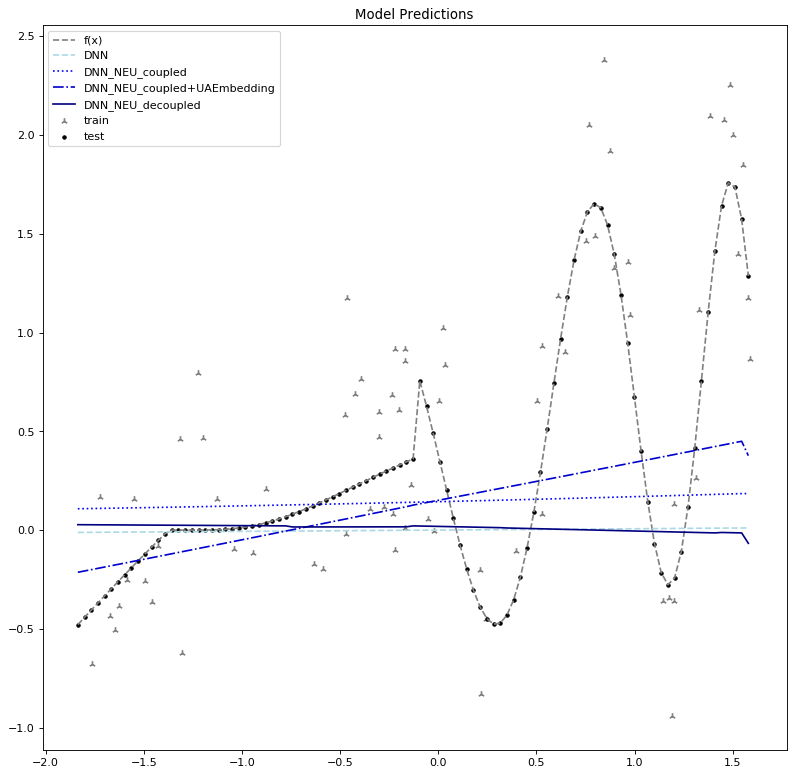

In [29]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Plot ffNN
plt.plot(np.array(data_x_test_raw).reshape(-1,),ffNN_y_hat_test, color = 'lightblue',linestyle="--",  label='DNN')


#--------------#
# NEU-Model(s) #
#--------------#
# Plot NEU-ffNN (Training Variants)
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test, linestyle=":", color = 'b',label='DNN_NEU_coupled')
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test_w_proj, color = 'mediumblue',linestyle='-.', label='DNN_NEU_coupled+UAEmbedding')
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test_Dcpld, color = 'navy',label='DNN_NEU_decoupled')


# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Neural_Network_Models.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

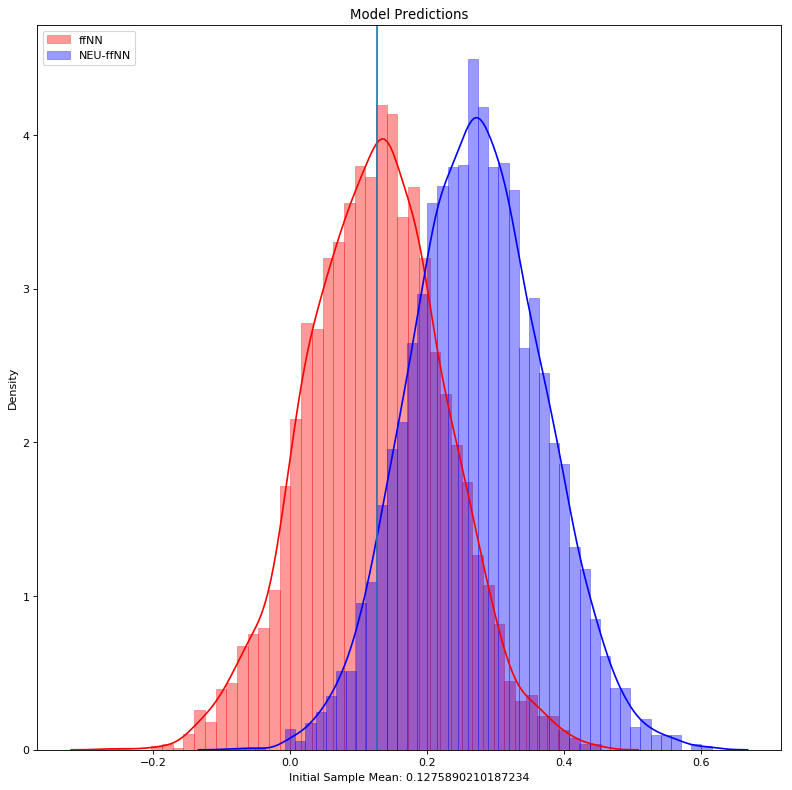

In [30]:
get_Error_distribution_plots(data_y_test,ffNN_y_hat_test,NEU_ffNN_y_hat_test,"ffNN")

---
---
---

---
# Result(s)
---

## Generate Results Table(s):

In [31]:
#==========#
# Training #
#==========#
train_performance  = pd.DataFrame({"Smoothin Splines": reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test).iloc[:,0],
                                   "LOESS": reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test).iloc[:,0],
#                                    "OLS": reporter(OLS_y_hat_train,OLS_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "Elastic Net": reporter(ENET_OLS_y_hat_train,ENET_OLS_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-OLS": reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "Kernel": reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-KerRidge": reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "GBRF": reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-GBRF": reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "ffNN": reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-ffNN (Readout-Form)": reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test).iloc[:,0],
                                   "NEU-ffNN (Coupled)": reporter(NEU_ffNN_y_hat_train_w_proj,NEU_ffNN_y_hat_test_w_proj,data_y,data_y_test).iloc[:,0],
                                   "NEU-ffNN (Decoupled)": reporter(NEU_ffNN_y_hat_train_Dcpld,NEU_ffNN_y_hat_test_Dcpld,data_y,data_y_test).iloc[:,0]}).transpose()

train_performance.to_latex("./outputs/tables/Train_performance.tex")

#=========#
# Testing #
#=========#
test__performance  = pd.DataFrame({"Smoothin Splines": reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test).iloc[:,1],
                                   "LOESS": reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test).iloc[:,1],
#                                    "OLS": reporter(OLS_y_hat_train,OLS_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "Elastic Net": reporter(ENET_OLS_y_hat_train,ENET_OLS_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-OLS": reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "Kernel": reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-KerRidge": reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "GBRF": reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-GBRF": reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "ffNN": reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-ffNN (Readout-Form)": reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test).iloc[:,1],
                                   "NEU-ffNN (Coupled)": reporter(NEU_ffNN_y_hat_train_w_proj,NEU_ffNN_y_hat_test_w_proj,data_y,data_y_test).iloc[:,1],
                                   "NEU-ffNN (Decoupled)": reporter(NEU_ffNN_y_hat_train_Dcpld,NEU_ffNN_y_hat_test_Dcpld,data_y,data_y_test).iloc[:,1]}).transpose()

test__performance.to_latex("./outputs/tables/Test_performance.tex")

# Visualize Predictions

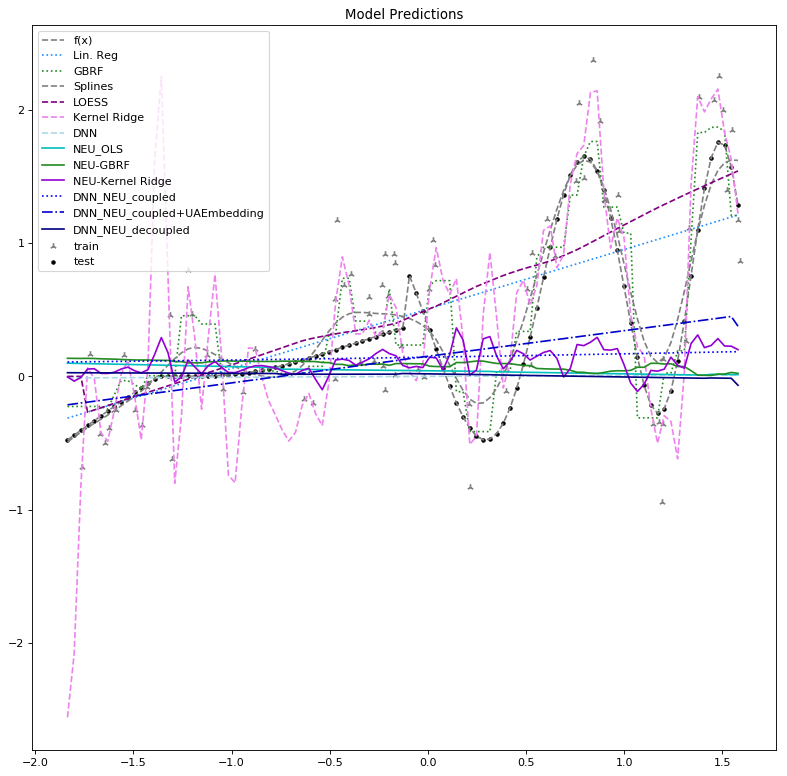

In [32]:
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

# Generate Plots #
#----------------#

# Plot Signal
plt.plot(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='gray',label='f(x)',linestyle='--')
# Plot Data
plt.scatter(np.array(data_x_raw).reshape(-1,),data_y,color='gray',label='train', marker = '2')
plt.scatter(np.array(data_x_test_raw).reshape(-1,),data_y_test,color='black',label='test', marker = '.')

#--------------------#
# Benchmark Model(s) #
#--------------------#
# Ordinary Linear Regression (OLS)
plt.plot(np.array(data_x_test_raw).reshape(-1,),ENET_OLS_y_hat_test, color = 'dodgerblue',linestyle=":", label='Lin. Reg')
# plt.plot(np.array(data_x_test_raw).reshape(-1,),OLS_y_hat_test, color = 'dodgerblue',linestyle=":", label='OLS')
# Plot Gradient-Boosted Random Forest Regressor (GBRF):
plt.plot(np.array(data_x_test_raw).reshape(-1,),GBRF_y_hat_test, color = 'forestgreen',linestyle=":", label='GBRF')
# Plot Non-Linar Benchmark(s): Classical
plt.plot(np.array(data_x_test_raw).reshape(-1,),f_hat_smoothing_splines_test,color='grey',linestyle="--",label='Splines')
plt.plot(np.array(data_x_test_raw).reshape(-1,),LOESS_prediction_test,color='purple',linestyle="--",label='LOESS')
# Kernel Ridge Regressor
plt.plot(np.array(data_x_test_raw).reshape(-1,),f_hat_kernel_ridge_test,color='violet',linestyle="--",label='Kernel Ridge')
# Plot ffNN
plt.plot(np.array(data_x_test_raw).reshape(-1,),ffNN_y_hat_test, color = 'lightblue',linestyle="--",  label='DNN')


#--------------#
# NEU-Model(s) #
#--------------#
# Plot NEU-OLS
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_OLS_y_hat_test, color = 'c',label='NEU_OLS')
# Plot NEU-GBRF:
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_GBRF_y_hat_test, color = 'forestgreen',label='NEU-GBRF')
# NEU-Kernel Ridge Regressor
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_KReg_y_hat_test,color='darkviolet',label='NEU-Kernel Ridge')
# Plot NEU-ffNN (Training Variants)
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test, linestyle=":", color = 'b',label='DNN_NEU_coupled')
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test_w_proj, color = 'mediumblue',linestyle='-.', label='DNN_NEU_coupled+UAEmbedding')
plt.plot(np.array(data_x_test_raw).reshape(-1,),NEU_ffNN_y_hat_test_Dcpld, color = 'navy',label='DNN_NEU_decoupled')


# Format Plot #
#-------------#
plt.legend(loc="upper left")
plt.title("Model Predictions")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Full_Picture.pdf', format='pdf')
# Show Plot
if is_visuallty_verbose == True:
    plt.show(block=False)

 ---

## Performance Report
- First, we print the comparison tables (so it can be viewed from the command-line if it is being run live on a grid/cluster/remotely).
- Second, we display the training and testing performances in clean dataframes.

In [33]:
#--------------------#
# Classical Model(s) #
#--------------------#
# OLS Performance
print("OLS-Performance:")
# print(reporter(OLS_y_hat_train,OLS_y_hat_test,data_y,data_y_test))

# NEU-OLS Performance
print("NEU-OLS-Performance:")
print(reporter(NEU_OLS_y_hat_train,NEU_OLS_y_hat_test,data_y,data_y_test))

OLS-Performance:
NEU-OLS-Performance:
                Train         Test
Er. 95L      0.276890     0.119803
Er. Mean     0.461152     0.236551
Er. 95U      0.647828     0.360337
MAE          0.709040     0.447292
MSE          0.870286     0.436004
MAPE      3614.691361  1981.756680


In [34]:
#-----------------------#
# Kernel Ridge Model(s) #
#-----------------------#
# Kernel Ridge Performance
print("Kernel Ridge-Performance:")
print(reporter(f_hat_kernel_ridge_train,f_hat_kernel_ridge_test,data_y,data_y_test))

# NEU-Kernel Ridge Performance
print("NEU-Kernel Ridge-Performance:")
print(reporter(NEU_KReg_y_hat_train,NEU_KReg_y_hat_test,data_y,data_y_test))

Kernel Ridge-Performance:
              Train        Test
Er. 95L   -0.051940   -0.206936
Er. Mean   0.000062   -0.090666
Er. 95U    0.051027    0.023175
MAE        0.162635    0.428352
MSE        0.052051    0.349560
MAPE      57.592129  178.340369
NEU-Kernel Ridge-Performance:
                Train        Test
Er. 95L      0.234985    0.070247
Er. Mean     0.392945    0.177866
Er. 95U      0.555713    0.290780
MAE          0.626142    0.410030
MSE          0.666075    0.348442
MAPE      2216.392570  903.501597


In [35]:
#---------------#
# Tree Model(s) #
#---------------#
# GBRF Performance
print("GBRF-Performance:")
print(reporter(GBRF_y_hat_train,GBRF_y_hat_test,data_y,data_y_test))

# NEU-GBRF Performance
print("NEU-GBRF-Performance:")
print(reporter(NEU_GBRF_y_hat_train,NEU_GBRF_y_hat_test,data_y,data_y_test))

GBRF-Performance:
                 Train        Test
Er. 95L  -6.034038e-02   -0.155394
Er. Mean -4.218847e-17   -0.107248
Er. 95U   5.967521e-02   -0.059649
MAE       2.156814e-01    0.199944
MSE       6.948222e-02    0.074269
MAPE      1.055031e+03  133.209419
NEU-GBRF-Performance:
                Train         Test
Er. 95L      0.238823     0.078393
Er. Mean     0.423367     0.196695
Er. 95U      0.611686     0.320277
MAE          0.710289     0.453193
MSE          0.867916     0.436599
MAPE      2873.340017  1484.753436


In [36]:
#-----------------------------------------------------#
# Classical Non-Linear Univariate Regression Model(s) #
#-----------------------------------------------------#
# Splines Performance
print("Splines-Performance:")
print(reporter(f_hat_smoothing_splines_train,f_hat_smoothing_splines_test,data_y,data_y_test))

# Loess Performance
print("LOESS Performance:")
print(reporter(LOESS_prediction_train,LOESS_prediction_test,data_y,data_y_test))

Splines-Performance:
                 Train        Test
Er. 95L  -9.469752e-02   -0.129807
Er. Mean -2.740030e-15   -0.099360
Er. 95U   9.269024e-02   -0.069758
MAE       3.464587e-01    0.142798
MSE       1.713013e-01    0.033205
MAPE      1.385319e+02  252.421497
LOESS Performance:
               Train      Test
Er. 95L    -0.234840 -0.346867
Er. Mean   -0.081312 -0.249485
Er. 95U     0.066390 -0.154751
MAE         0.516861  0.370848
MSE         0.457810  0.313624
MAPE      222.188973       inf


In [37]:
#--------------#
# DNN Model(s) #
#--------------#
# ffNN Performance
print("ffNN-Performance:")
print(reporter(ffNN_y_hat_train,ffNN_y_hat_test,data_y,data_y_test))

# NEU-ffNN Performance
print("NEU-ffNN (Coupled) Performance:")
print(reporter(NEU_ffNN_y_hat_train,NEU_ffNN_y_hat_test,data_y,data_y_test))
print("NEU-ffNN (Coupled+UAEmbedding) Performance:")
print(reporter(NEU_ffNN_y_hat_train_w_proj,NEU_ffNN_y_hat_test_w_proj,data_y,data_y_test))
print("NEU-ffNN (Decoupled) Performance:")
print(reporter(NEU_ffNN_y_hat_train_Dcpld,NEU_ffNN_y_hat_test_Dcpld,data_y,data_y_test))

ffNN-Performance:
                 Train          Test
Er. 95L       0.327462      0.171847
Er. Mean      0.505723      0.285458
Er. 95U       0.687749      0.406307
MAE           0.713892      0.438525
MSE           0.885243      0.437244
MAPE      27059.295252  28211.370041
NEU-ffNN (Coupled) Performance:
               Train        Test
Er. 95L     0.185426    0.030836
Er. Mean    0.359950    0.141865
Er. 95U     0.538672    0.260767
MAE         0.668088    0.421869
MSE         0.744829    0.364326
MAPE      435.629980  275.598688
NEU-ffNN (Coupled+UAEmbedding) Performance:
               Train        Test
Er. 95L     0.194551    0.066758
Er. Mean    0.352777    0.162961
Er. 95U     0.517041    0.263360
MAE         0.622403    0.372492
MSE         0.627648    0.283270
MAPE      377.366900  253.827737
NEU-ffNN (Decoupled) Performance:
                 Train          Test
Er. 95L       0.308104      0.156611
Er. Mean      0.489368      0.273606
Er. 95U       0.678345      0.395289
MAE

# Report

## Re-Summarize Learning Problem for easy recap :)

In [38]:
print("Simulation Confiugration Information:")
print(" ")
print("=========================================================================================================================================================")
print(the_facts)
print("=========================================================================================================================================================")
print(" ")

Simulation Confiugration Information:
 
We're plotting the function: the_nightmare with 0.5 additive noise, a distortion/model uncertainty level of0, and an out-of sample window on either side of the input space of:0.01.  We train using 100 datapoints and have a test set conisting of 0.75% percent of the total generated data.
 


## Train-Set Performance

In [39]:
train_performance

,Er. 95L,Er. Mean,Er. 95U,MAE,MSE,MAPE
Smoothin Splines,-0.093225,-2.740030e-15,0.095335,0.346459,0.171301,138.531950
LOESS,-0.236157,-8.131150e-02,0.065890,0.516861,0.457810,222.188973
Elastic Net,-0.148602,6.957398e-17,0.146441,0.518138,0.436216,215.184926
NEU-OLS,0.278839,4.611519e-01,0.645820,0.709040,0.870286,3614.691361
Kernel,-0.052991,6.223346e-05,0.050778,0.162635,0.052051,57.592129
NEU-KerRidge,0.233949,3.929452e-01,0.555183,0.626142,0.666075,2216.392570
GBRF,-0.057812,-4.218847e-17,0.058840,0.215681,0.069482,1055.030948
NEU-GBRF,0.238877,4.233668e-01,0.611613,0.710289,0.867916,2873.340017
ffNN,0.331513,5.057235e-01,0.684829,0.713892,0.885243,27059.295252
NEU-ffNN (Readout-Form),0.188249,3.599496e-01,0.542660,0.668088,0.744829,435.629980


## Test-Set Performance

In [40]:
test__performance

,Er. 95L,Er. Mean,Er. 95U,MAE,MSE,MAPE
Smoothin Splines,-0.128796,-0.099360,-0.069696,0.142798,0.033205,2.524215e+02
LOESS,-0.347489,-0.249485,-0.153995,0.370848,0.313624,inf
Elastic Net,-0.262082,-0.163956,-0.071229,0.342560,0.258838,6.441517e+01
NEU-OLS,0.118810,0.236551,0.360089,0.447292,0.436004,1.981757e+03
Kernel,-0.204927,-0.090666,0.023547,0.428352,0.349560,1.783404e+02
NEU-KerRidge,0.069571,0.177866,0.288270,0.410030,0.348442,9.035016e+02
GBRF,-0.156934,-0.107248,-0.059710,0.199944,0.074269,1.332094e+02
NEU-GBRF,0.076947,0.196695,0.322832,0.453193,0.436599,1.484753e+03
ffNN,0.175360,0.285458,0.405348,0.438525,0.437244,2.821137e+04
NEU-ffNN (Readout-Form),0.032436,0.141865,0.257228,0.421869,0.364326,2.755987e+02


#### The END

---